# 02. Neural Network classification with PyTorch

Classification is a problem of predicting wether something is one thing or another (there can be multple things as options).

In [326]:
import torch
from torch import nn
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import requests

## Make classification data

In [327]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [328]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [329]:
# Make a DataFrame of circle data
circles = pd.DataFrame({"x1": X[:, 0],
                        "x2": X[:, 1],
                        "label": y})
circles.head(5)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


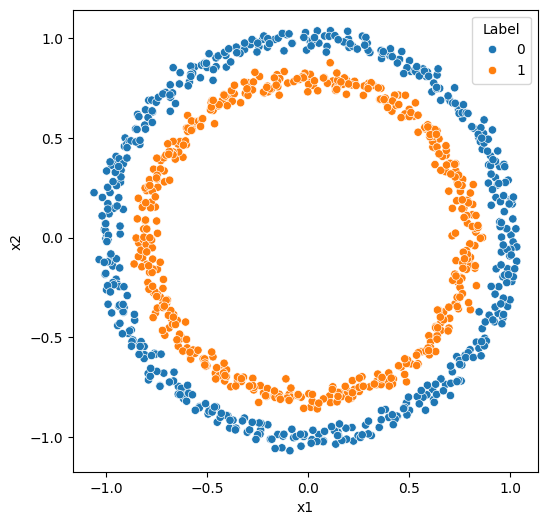

In [330]:
# Visualize
plt.figure(figsize=(6, 6))
sns.scatterplot(data=circles, x="x1", y="x2", hue="label")
plt.legend(title="Label");

### Check input and output shapes

In [331]:
X.shape, y.shape

((1000, 2), (1000,))

In [332]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors

In [333]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [334]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## Building a model

Let's build a model to classify our orange and blue dots.

To do so, we want to:
1. Set up device agnostic code (to practice good habits)
2. Construct a model (by sublassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [335]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Now we have setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target device

In [336]:
# 1. Create a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


In [337]:
# 4. Instantiate an instance and send it to the target device
model_0 = CircleModelV0().to(device)

model_0, next(model_0.parameters()).device

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [338]:
# Let's replicate the model above using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0, next(model_0.parameters()).device

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [339]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of predictions: {len(X_test)}, Shape: {X_test.shape}")
print()
print(f"First 10 predictions:\n{torch.round(untrained_preds[:10]).squeeze()}")
print(f"Frist 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of predictions: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([-1., -1., -0., -1., -0., -0., -1., -1., -0., -1.])
Frist 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Set up loss funciton and optimizer

Which loss function or optimizer should you use?

* For regression you might want *MAE* or *MSE*.
* For classification you might want *binary cross entropy* or *categorical cross entropy*.

As a reminder, the loss function measures how *wrong* your predictions are.
And for optimizers, two of the most common and useful are *SGD* and *Adam*, however, PyTorch has a lot more of them integrated.

* For the loss function we're goiing to use `torch.nn.BCEWithLogits()`

In [340]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

In [341]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct / len(y_pred) * 100
  return acc

## Train the model

To train the model we will need to build an optimization loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert this **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can conver our model prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [342]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.6471],
        [-0.7051],
        [-0.4180],
        [-0.7124],
        [-0.2956]])

In [343]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [344]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3436],
        [0.3307],
        [0.3970],
        [0.3291],
        [0.4266]])

For our prediction probability values, we need to perform a range-style rounding them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [345]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [346]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building a training and testing loop

In [347]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Building training and testing loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

  # 2. Calculate the loss / accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects logits as inputs
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  if epoch % 20 == 0:
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate test loss
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

      # 3. Print out what's happening
      print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train acc: {acc:.2f}% | Test Loss: {test_loss} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.72501 | Train acc: 50.00% | Test Loss: 0.7172608971595764 | Test acc: 50.00%
Epoch: 20 | Train Loss: 0.69763 | Train acc: 46.25% | Test Loss: 0.693202793598175 | Test acc: 49.50%
Epoch: 40 | Train Loss: 0.69503 | Train acc: 48.50% | Test Loss: 0.6917670965194702 | Test acc: 51.00%
Epoch: 60 | Train Loss: 0.69416 | Train acc: 48.88% | Test Loss: 0.6918814182281494 | Test acc: 52.50%
Epoch: 80 | Train Loss: 0.69369 | Train acc: 48.75% | Test Loss: 0.692197322845459 | Test acc: 53.00%


## Make predictions and evaluate the model

From the metrics it looks like our model is not learning anything...

To inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [348]:
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if (Path("helper_functions.py").is_file()):
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


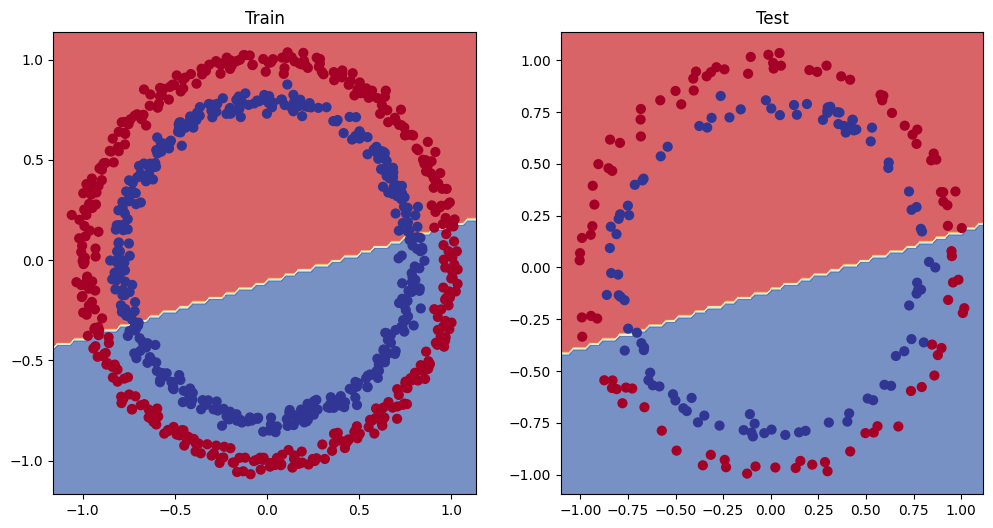

In [349]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model prespective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - from 5 hidden units (neurons) to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function


Let's try and improve our model by:
* Adding more hidden units. 5 -> 10
* Increase the number of layers. 2 -> 3
* Increate the number of epochs: 100 -> 1000

In [350]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.Linear(in_features=10, out_features=10),
        nn.Linear(in_features=10, out_features=1)
    )

  def forward(self, x):
    return self.layers(x)

In [351]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [352]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [353]:
# Write a training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  train_logits = model_1(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(train_logits)) # logits -> pred probabilities -> pred labels

  # 2. Calculate loss/accuracy
  train_loss = loss_fn(train_logits, y_train)
  train_acc = accuracy_fn(y_true=y_train, y_pred=train_preds)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  train_loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate loss
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

      # 3. Print out what's happening
      print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test Loss: {test_loss} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69396 | Train acc: 50.88% | Test Loss: 0.6926146149635315 | Test acc: 51.00%
Epoch: 100 | Train Loss: 0.69305 | Train acc: 50.38% | Test Loss: 0.6937903761863708 | Test acc: 48.00%
Epoch: 200 | Train Loss: 0.69299 | Train acc: 51.12% | Test Loss: 0.6943727731704712 | Test acc: 46.00%
Epoch: 300 | Train Loss: 0.69298 | Train acc: 51.62% | Test Loss: 0.6945767998695374 | Test acc: 45.00%
Epoch: 400 | Train Loss: 0.69298 | Train acc: 51.12% | Test Loss: 0.6946452260017395 | Test acc: 46.00%
Epoch: 500 | Train Loss: 0.69298 | Train acc: 51.00% | Test Loss: 0.6946679949760437 | Test acc: 46.00%
Epoch: 600 | Train Loss: 0.69298 | Train acc: 51.00% | Test Loss: 0.6946756839752197 | Test acc: 46.00%
Epoch: 700 | Train Loss: 0.69298 | Train acc: 51.00% | Test Loss: 0.6946782469749451 | Test acc: 46.00%
Epoch: 800 | Train Loss: 0.69298 | Train acc: 51.00% | Test Loss: 0.6946792006492615 | Test acc: 46.00%
Epoch: 900 | Train Loss: 0.69298 | Train acc: 51.00% | Test Loss: 

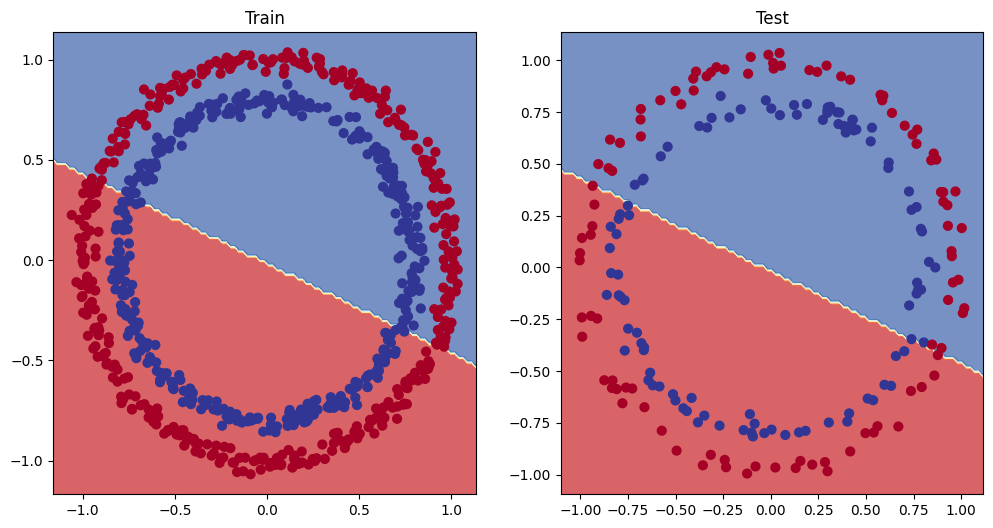

In [354]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to se if our model can learn a straight line

One way to troubleshoot a larger problem is to test out a samller problem.

In [355]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
len(X_regression)

100

In [356]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

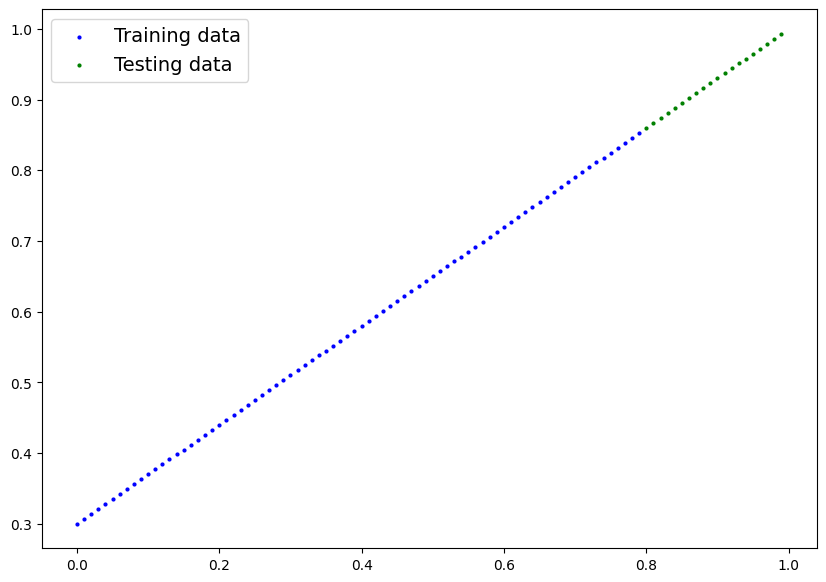

In [357]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

### Adjust `model_1` to fit a straight line

In [358]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [359]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [360]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Trainig
  model_2.train()

  # 1. Forward pass
  train_preds = model_2(X_train_regression)

  # 2. Calculate loss
  train_loss = loss_fn(train_preds, y_train_regression)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  train_loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_preds = model_2(X_test_regression)

      # 2. Calculate loss
      test_loss = loss_fn(test_preds, y_test_regression)

      # 3. Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.7598584890365601 | Test loss: 0.9110288619995117
Epoch: 100 | Train loss: 0.02857953868806362 | Test loss: 0.0008127152686938643
Epoch: 200 | Train loss: 0.025325417518615723 | Test loss: 0.002092066453769803
Epoch: 300 | Train loss: 0.021374788135290146 | Test loss: 0.0030509470961987972
Epoch: 400 | Train loss: 0.019644945859909058 | Test loss: 0.003407782409340143
Epoch: 500 | Train loss: 0.019402235746383667 | Test loss: 0.0038725673221051693
Epoch: 600 | Train loss: 0.019032442942261696 | Test loss: 0.003789058420807123
Epoch: 700 | Train loss: 0.01878291741013527 | Test loss: 0.003813347313553095
Epoch: 800 | Train loss: 0.01839740015566349 | Test loss: 0.0032872825395315886
Epoch: 900 | Train loss: 0.017980266362428665 | Test loss: 0.00360372057184577


In [361]:
with torch.inference_mode():
  regression_preds = model_2(X_test_regression)

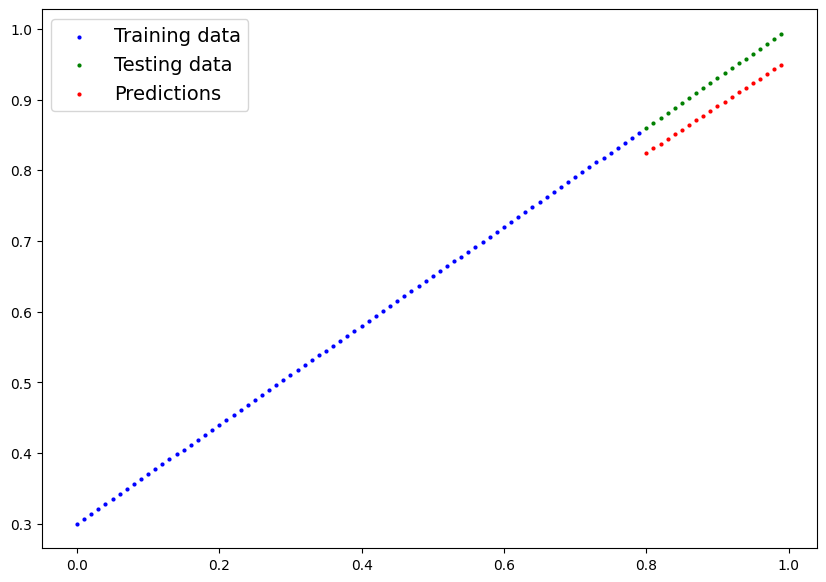

In [362]:
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=regression_preds.cpu())

## The missing piece: non-linearity

What patters could you draw if you were given an infinite amount of straight and non-straight lines?

Or in machine learning terms, an infinite amount of linear and non-linear functions.

### Recreating non-linear data (blue and orange circles)

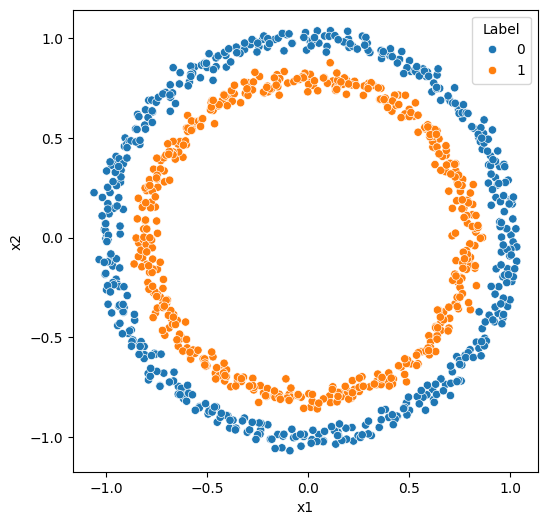

In [363]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Make a DataFrame of circle data
circles = pd.DataFrame({"x1": X[:, 0],
                        "x2": X[:, 1],
                        "label": y})
circles.head(5)

# Visualize
plt.figure(figsize=(6, 6))
sns.scatterplot(data=circles, x="x1", y="x2", hue="label")
plt.legend(title="Label");

In [364]:
# Convert data to tensors and then to train/test splits

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

### Building a model with non-linearity

In [365]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=1)
    )

  def forward(self, x):
    return self.layers(x)

In [366]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [367]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.07)

In [368]:
# Write a training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 3000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_3.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  train_logits = model_3(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(train_logits)) # logits -> pred probabilities -> pred labels

  # 2. Calculate loss/accuracy
  train_loss = loss_fn(train_logits, y_train)
  train_acc = accuracy_fn(y_true=y_train, y_pred=train_preds)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  train_loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate loss
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

      # 3. Print out what's happening
      print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test Loss: {test_loss} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69296 | Train acc: 49.75% | Test Loss: 0.6931379437446594 | Test acc: 51.00%
Epoch: 100 | Train Loss: 0.69155 | Train acc: 51.75% | Test Loss: 0.691646933555603 | Test acc: 51.50%
Epoch: 200 | Train Loss: 0.69073 | Train acc: 52.38% | Test Loss: 0.6905637979507446 | Test acc: 51.50%
Epoch: 300 | Train Loss: 0.68980 | Train acc: 52.00% | Test Loss: 0.6892830729484558 | Test acc: 53.50%
Epoch: 400 | Train Loss: 0.68864 | Train acc: 52.50% | Test Loss: 0.6876928806304932 | Test acc: 54.00%
Epoch: 500 | Train Loss: 0.68718 | Train acc: 52.62% | Test Loss: 0.6857236623764038 | Test acc: 56.50%
Epoch: 600 | Train Loss: 0.68530 | Train acc: 52.75% | Test Loss: 0.6832354664802551 | Test acc: 56.50%
Epoch: 700 | Train Loss: 0.68289 | Train acc: 52.75% | Test Loss: 0.680087149143219 | Test acc: 56.50%
Epoch: 800 | Train Loss: 0.67970 | Train acc: 53.00% | Test Loss: 0.6761525869369507 | Test acc: 57.00%
Epoch: 900 | Train Loss: 0.67553 | Train acc: 53.25% | Test Loss: 0.

### Evaluating a model trained with non-linear activation functions

In [369]:
# Make predictions
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0.]))

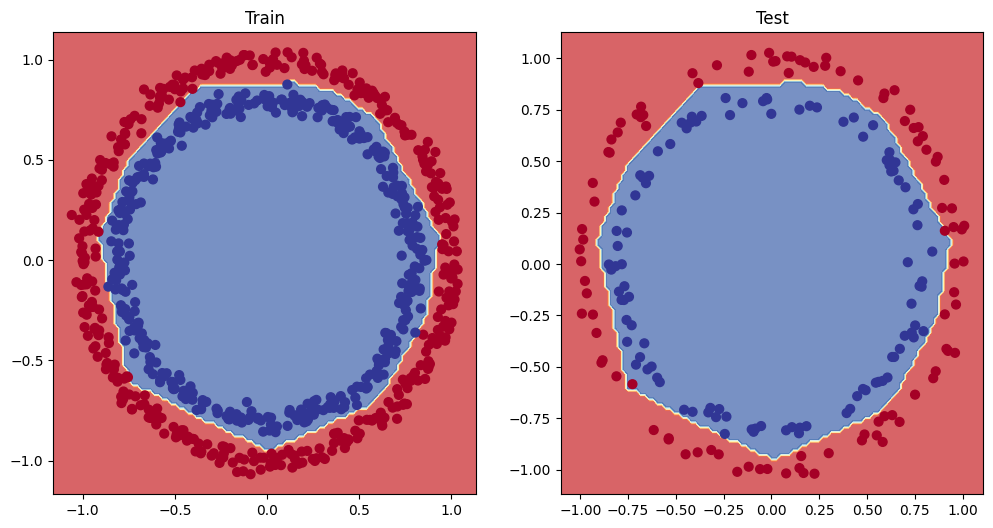

In [370]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non-linear activation functions

Rather than telling the model what to learn, we give it the tools to discover patterns in the data on its own.

And theese tools are linear & non-linear functions.

In [371]:
# Create a tensor
A = torch.arange(-10, 10, 1.0)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

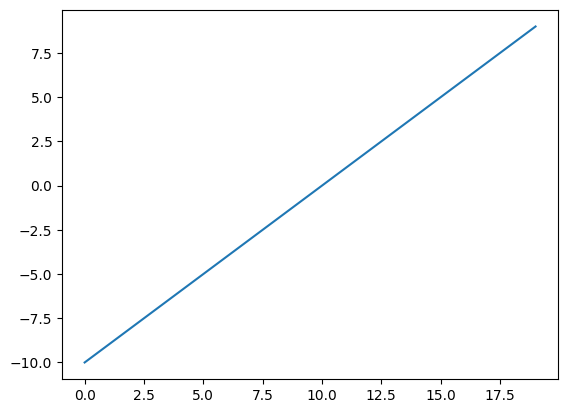

In [372]:
# Visualize the tensor
plt.plot(A);

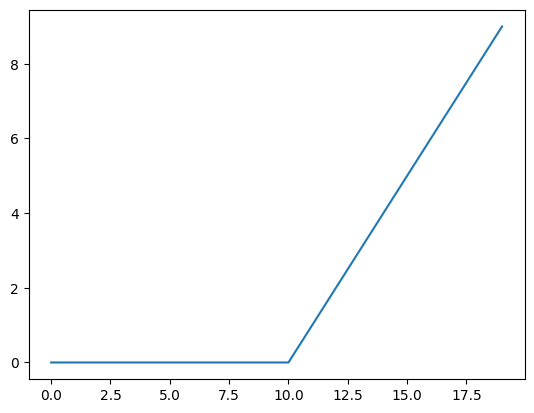

In [373]:
plt.plot(torch.relu(A));

In [374]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensors

In [375]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

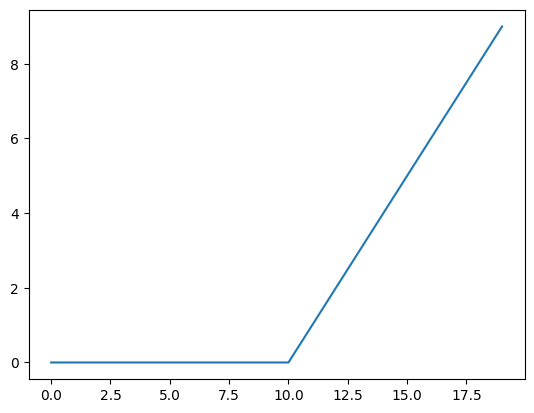

In [376]:
# Plot ReLU activation function
plt.plot((relu(A)));

In [377]:
# Now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

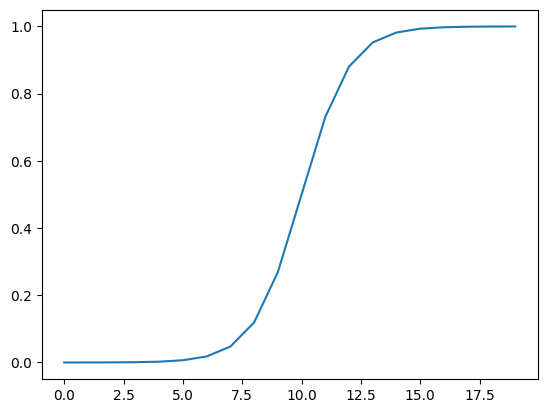

In [378]:
plt.plot(torch.sigmoid(A));

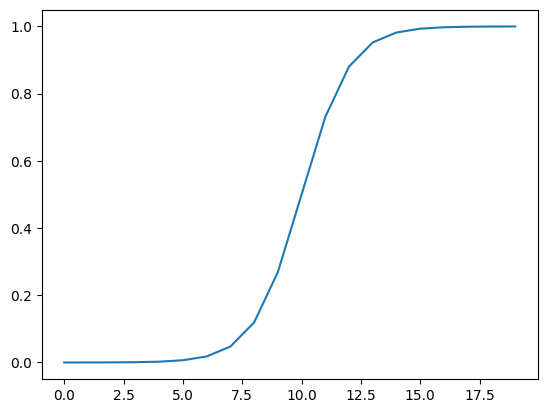

In [379]:
plt.plot(sigmoid(A));

## Putting everything together by building a multi-class PyTorch model

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam)
* Multi-class classification = more than one thing or another (cat or dog or fish)

### Creating multi-class classification data

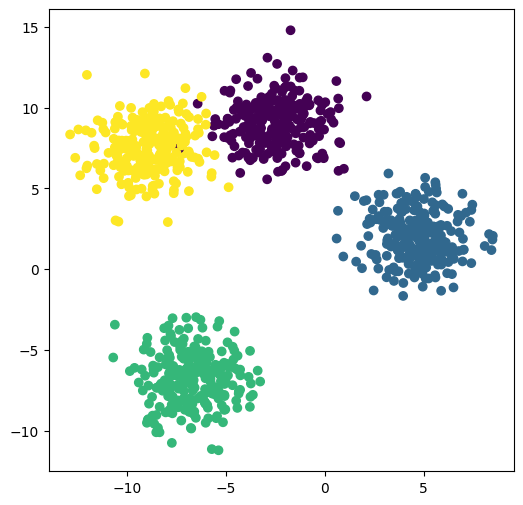

In [380]:
# Set up the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train/test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, train_size=0.8, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(6, 6))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap="viridis");

### Building a multi-class classification model

In [381]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [382]:
# Build a multi-class classification problem
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8
    """

    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(), # Note: ReLU Layers are not needed in this case since we can divide the data using straight lines (linear functions)
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # Note: ReLU Layers are not needed in this case since we can divide the data using straight lines (linear functions)
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.layers(x)

In [383]:
# Create an instance of blob model and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Create a loss function and an optimizer for a multi-class classification model

In [384]:
# Create loss function and optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

### Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to conver our model's logits to prediction probabilities and then to prediction labels.

1. Logits (raw model output)
2. Prediction probabilities (use `torch.softmax()`)
3. Prediction labels (take the argmax of the prediction probabilities)

In [385]:
# Let's get some raw outputs (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])

In [386]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])

In [387]:
# Convert prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0])

### Create optimization loop

In [388]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ### Train
  model_4.train()

  train_logits = model_4(X_blob_train)
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

  train_loss = loss_fn(train_logits, y_blob_train)
  train_acc = accuracy_fn(y_true=y_blob_train, y_pred=train_preds)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  ### Test
  if epoch % 20 == 0:
    model_4.eval()
    with torch.inference_mode():
      test_logits = model_4(X_blob_test)
      test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.15883 | Train acc: 40.38% | Test Loss: 1.07554 | Test acc: 48.00%
Epoch: 20 | Train Loss: 0.42535 | Train acc: 98.50% | Test Loss: 0.43074 | Test acc: 100.00%
Epoch: 40 | Train Loss: 0.11232 | Train acc: 99.25% | Test Loss: 0.10229 | Test acc: 99.50%
Epoch: 60 | Train Loss: 0.05068 | Train acc: 99.25% | Test Loss: 0.04293 | Test acc: 99.50%
Epoch: 80 | Train Loss: 0.03836 | Train acc: 99.25% | Test Loss: 0.02988 | Test acc: 99.50%


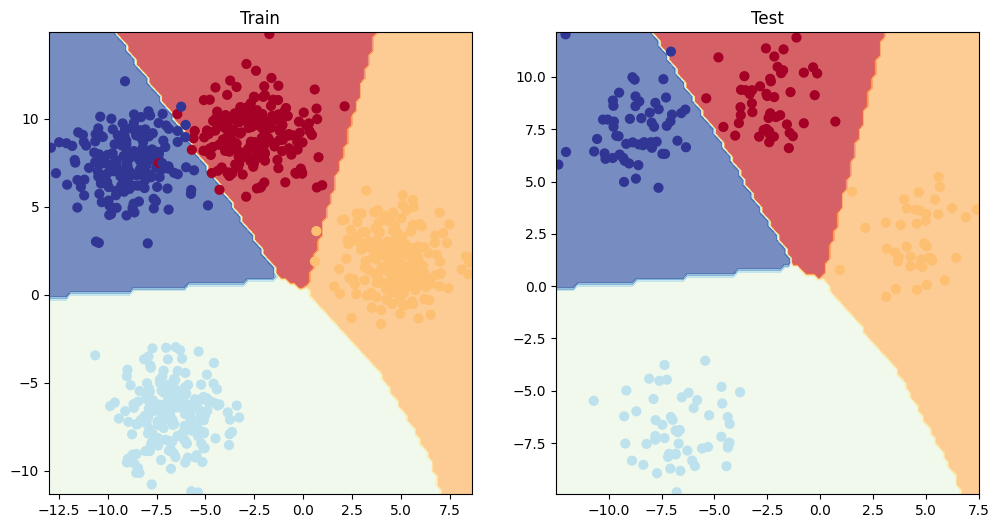

In [389]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### Making and evaluating predicitons

In [390]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 5 predictions
y_logits[:5]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466]])

In [391]:
# Go from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05]])

In [392]:
# Go from prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5], y_blob_test[:5]

(tensor([1, 3, 2, 1, 0]), tensor([1, 3, 2, 1, 0]))

## Some more classification metrics

* Accuracy - out of a 100 samples, how many does our model get right (not the best for imbalanced datasets)
* Precision - Higher precision leads to less false positives
* Recall - Higher recall leads to less false negatives
* F1-score
* Confussion matrix
* Classification report

In [393]:
# Accuracy metrics
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=4)
accuracy(y_preds, y_blob_test)

tensor(0.9950)

In [394]:
# Precision metrics
precision = torchmetrics.Precision(task='multiclass', num_classes=4)
precision(y_preds, y_blob_test)

tensor(0.9950)

In [395]:
# Recall metrics
recall = torchmetrics.Recall(task='multiclass', num_classes=4)
recall(y_preds, y_blob_test)

tensor(0.9950)

In [396]:
# F1 score metrics
f1 = torchmetrics.F1Score(task='multiclass', num_classes=4)
f1(y_preds, y_blob_test)

tensor(0.9950)

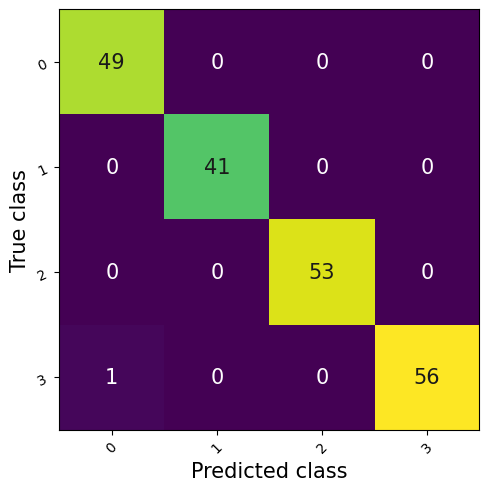

In [397]:
# Confussion matrix
metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=4)
metric.update(y_preds, y_blob_test)
fig_, ax_ = metric.plot()

In [398]:
# Classification report
print(classification_report(y_true=y_blob_test, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200

